***
- #### PREVISAO_QTD_CLIENTES_E_POTENCIA_INSTALADA_GD_EM_PERNAMBUCO
- #### AUTOR: IAGO GADE GUSMAO CARRAZZONI
<br>
    - Este projeto tem como objetivo conduzir um estudo sobre a previsibilidade da quantidade de clientes de GD e a potência instalada (kW) na rede em Pernambuco para os próximos anos, com o auxílio do aprendizado de máquina, para que seja possível ter uma noção de como será o cenário futuro da geração distribuída, com o intuito de auxiliar no planejamento da rede elétrica e evitar os problemas causados pela mudança no sistema de distribuição de eletricidade em Pernambuco.

***
# BIBLIOTECAS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
from datetime import timedelta, date
import io
#from google.colab import files

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse

from statsmodels.graphics.tsaplots import plot_acf

# Aumenta o comprimento das celulas do jupyter notebook
from IPython.display import display, HTML
display(HTML("<style>.container {width:100% !important;}</style>"))
# Mostra todas as colunas dos dataframes
pd.set_option('display.max_columns', None)
# Mostra todos os termos de um array
import sys
np.set_printoptions(threshold=sys.maxsize)

import warnings
warnings.filterwarnings("ignore")

# Tamanho dos graficos
plt.rcParams["figure.figsize"] = (10,6)
# https://colab.research.google.com/drive/13J1EjN-C8GKW1YFETHFjgeD_qPOhN_nw?usp=sharing
# https://colab.research.google.com/drive/1QdI7SELcWE5mgyrt7bcoWcqHQA6r_DJu?usp=sharing


***
# FUNÇÕES

In [2]:
# Funcao para multistep prediction com metodo iterativo
def itr_prev(model, testset, dimension, n):
    preds = []
    
    for l in range(len(testset)):
        
        aux_set = testset.iloc[l,]
        
        for x in range(n): 
            aux_pred = model.predict(np.array(aux_set).reshape(1,-1))
            aux_set = aux_set.shift(1)
            aux_set[0] = aux_pred
            
        preds.append(aux_pred)
    
    preds = pd.Series(preds)
    
    return preds


In [3]:
# Funcao para calcular melhores configuracoes do SVR
def gridSVR(X_train, Y_train, X_val, Y_val):
    C_r = range(-3,4)
    Epsilon_r = range(-3,4)
    Gamma_r = range(-3,4)
    
    bestModel=1
    bestError=9999999999999999
    bestPredicts=1
    bestParam=(0,0,0)
    for c in C_r:
        for e in Epsilon_r:
            for g in Gamma_r:
                model = SVR(C=10**c, gamma=10**g, epsilon=10**e)
                model.fit(X_train,Y_train)
                predicts = model.predict(X_val)
                erro = mse(Y_val,predicts)
                if (erro<bestError):
                    bestError=erro
                    bestModel=model
                    bestPredicts=predicts
                    bestParam=(c,g,e)
                    
    print ('Best Param (Grid SVR): '), bestParam
    return (bestModel, bestPredicts, bestError, bestParam)


In [4]:
# Funcao para plotar autocorrelacao
def acf_plot(data, lags):
    values=[]
    for i in range((lags)):
        values.append(data.autocorr(i))
   
    plt.plot(np.zeros_like(values))
    plt.plot(np.ones_like(values)*1.96*(1/np.sqrt(len(data))))
    plt.plot(np.ones_like(values)*(-1.96)*(1/np.sqrt(len(data))))
    plt.bar(range(lags),values,width=0.4)
    plt.title('Autocorrelation Plot')
    plt.xlabel('Lags')
    plt.ylabel('Autocorrelation')
    plt.show()


***
# ENTRADA DE DADOS

In [5]:
# Leitura da planilha "empreendimento-geracao-distribuida" da ANEEL
# Data de extracao: 14/09/2022

# Notebook
EMPREENDIMENTO_GD = pd.read_csv(r"C:\IAGO_GADE_GUSMAO_CARRAZZONI\TCC\ALGORITMO\BASES\empreendimento-geracao-distribuida.csv", sep=";", encoding="utf-16")

# Colaboratory
#uploaded = files.upload()
#EMPREENDIMENTO_GD = pd.read_csv(io.BytesIO(uploaded['empreendimento-geracao-distribuida.csv'], sep=";", encoding="utf-16"))

EMPREENDIMENTO_GD = EMPREENDIMENTO_GD.fillna(0)

EMPREENDIMENTO_GD.tail(5)


,DatGeracaoConjuntoDados,AnmPeriodoReferencia,NumCNPJDistribuidora,SigAgente,NomAgente,CodClasseConsumo,DscClasseConsumo,CodSubGrupoTarifario,DscSubGrupoTarifario,codUFibge,SigUF,codRegiao,NomRegiao,CodMunicipioIbge,NomMunicipio,CodCEP,SigTipoConsumidor,NumCPFCNPJ,NomeTitularEmpreendimento,CodEmpreendimento,DthAtualizaCadastralEmpreend,SigModalidadeEmpreendimento,DscModalidadeHabilitado,QtdUCRecebeCredito,SigTipoGeracao,DscFonteGeracao,DscPorte,MdaPotenciaInstaladaKW,NumCoordNEmpreendimento,NumCoordEEmpreendimento,NomSubEstacao,NumCoordESub,NumCoordNSub
1242595,2022-09-13,09/2022,2.508603e+13,ETO,ENERGISA TOCANTINS DISTRIBUIDORA DE ENERGIA S.A.,3,Rural,10,B2,17.0,TO,1702.0,Norte,1714203.0,Natividade,77370***,PF,***.020.371-**,***,GD.TO.001.185.200,2022-08-26,R,Caracterizada como Autoconsumo remoto,3,UFV,Radiação solar,Microgeracao,"8,00",0,0,0,0,0
1242596,2022-09-13,09/2022,2.508603e+13,ETO,ENERGISA TOCANTINS DISTRIBUIDORA DE ENERGIA S.A.,1,Residencial,9,B1,17.0,TO,1702.0,Norte,1721000.0,Palmas,77000***,PF,***.285.201-**,***,GD.TO.001.185.201,2022-08-17,P,Com Microgeracao ou Minigeracao distribuida,1,UFV,Radiação solar,Microgeracao,"5,00",0,0,0,0,0
1242597,2022-09-13,09/2022,2.508603e+13,ETO,ENERGISA TOCANTINS DISTRIBUIDORA DE ENERGIA S.A.,1,Residencial,9,B1,17.0,TO,1701.0,Norte,1702109.0,Araguaína,77823***,PF,***.679.532-**,***,GD.TO.001.185.202,2022-08-05,P,Com Microgeracao ou Minigeracao distribuida,1,UFV,Radiação solar,Microgeracao,"5,00",0,0,0,0,0
1242598,2022-09-13,09/2022,3.305007e+13,ENEL RJ,AMPLA ENERGIA E SERVIÇOS S.A.,1,Residencial,9,B1,17.0,TO,1702.0,Norte,1714203.0,Natividade,28380***,PF,***.155.387-**,***,GD.TO.001.189.646,2022-07-21,R,Caracterizada como Autoconsumo remoto,3,UFV,Radiação solar,Microgeracao,"8,50",0,0,0,0,0
1242599,2022-09-13,09/2022,1.301746e+13,ESE,ENERGISA SERGIPE - DISTRIBUIDORA DE ENERGIA S.A,2,Comercial,11,B3,17.0,TO,1701.0,Norte,1701002.0,Ananás,77890000,PJ,38144119000100,JOSE DOCARMO FILHO,GD.TO.001.210.055,2020-04-28,P,Com Microgeracao ou Minigeracao distribuida,1,UFV,Radiação solar,Microgeracao,"27,00","-6,37","-48,07",0,0,0


In [6]:
EMPREENDIMENTO_GD.columns

Index(['DatGeracaoConjuntoDados', 'AnmPeriodoReferencia',
       'NumCNPJDistribuidora', 'SigAgente', 'NomAgente', 'CodClasseConsumo',
       'DscClasseConsumo', 'CodSubGrupoTarifario', 'DscSubGrupoTarifario',
       'codUFibge', 'SigUF', 'codRegiao', 'NomRegiao', 'CodMunicipioIbge',
       'NomMunicipio', 'CodCEP', 'SigTipoConsumidor', 'NumCPFCNPJ',
       'NomeTitularEmpreendimento', 'CodEmpreendimento',
       'DthAtualizaCadastralEmpreend', 'SigModalidadeEmpreendimento',
       'DscModalidadeHabilitado', 'QtdUCRecebeCredito', 'SigTipoGeracao',
       'DscFonteGeracao', 'DscPorte', 'MdaPotenciaInstaladaKW',
       'NumCoordNEmpreendimento', 'NumCoordEEmpreendimento', 'NomSubEstacao',
       'NumCoordESub', 'NumCoordNSub'],
      dtype='object')

***
# TRATATIVA DOS DADOS

In [7]:
# Filtrando clientes de Pernambuco pela UF
EMPREENDIMENTO_GD = EMPREENDIMENTO_GD[EMPREENDIMENTO_GD['SigUF'] == 'PE']

# Analisa qual a quantidade de clientes de Minigeracao e Microgeracao
EMPREENDIMENTO_GD['DscPorte'].value_counts()

Microgeracao    36324
Minigeracao       319
Name: DscPorte, dtype: int64

In [8]:
# Analisa qual a porcentagem de clientes de Minigeracao e Microgeracao
EMPREENDIMENTO_GD['DscPorte'].value_counts(normalize=True)

Microgeracao    0.991294
Minigeracao     0.008706
Name: DscPorte, dtype: float64

In [9]:
# Resetando o indice
EMPREENDIMENTO_GD.reset_index(drop=True, inplace=True)

# Transformando a coluna para tipo data
EMPREENDIMENTO_GD['DthAtualizaCadastralEmpreend'] = pd.to_datetime(EMPREENDIMENTO_GD['DthAtualizaCadastralEmpreend'])

# Ordenando data em ordem crescente
EMPREENDIMENTO_GD = EMPREENDIMENTO_GD.sort_values(['DthAtualizaCadastralEmpreend'], ascending = [True])

# Filtrando colunas desejadas
EMPREENDIMENTO_GD = EMPREENDIMENTO_GD[['DthAtualizaCadastralEmpreend', 'MdaPotenciaInstaladaKW']]
EMPREENDIMENTO_GD['quantidade_clientes'] = 1
EMPREENDIMENTO_GD.rename(columns={'DthAtualizaCadastralEmpreend':'data_conexao', 'MdaPotenciaInstaladaKW':'potencia_instalada_kw'}, inplace=True)

# Resetando o indice
EMPREENDIMENTO_GD.reset_index(drop=True, inplace=True)

# Convertendo a potencia de string para float
EMPREENDIMENTO_GD['potencia_instalada_kw'] = EMPREENDIMENTO_GD['potencia_instalada_kw'].str.replace(',', '.')
EMPREENDIMENTO_GD['potencia_instalada_kw'] = EMPREENDIMENTO_GD['potencia_instalada_kw'].astype(float)

# Criando colunas de ano e mes
EMPREENDIMENTO_GD['ano'] = pd.DatetimeIndex(EMPREENDIMENTO_GD['data_conexao']).year
EMPREENDIMENTO_GD['mes'] = pd.DatetimeIndex(EMPREENDIMENTO_GD['data_conexao']).month

# Adicionando '0' antes dos meses para padronizar a chave
EMPREENDIMENTO_GD['mes'] = EMPREENDIMENTO_GD['mes'].astype(str)
j = 0
for i in EMPREENDIMENTO_GD['mes']:
    if i != '10' and i != '11' and i != '12':
        EMPREENDIMENTO_GD.loc[j, 'mes'] = "0" + i
    j += 1

# Criar chave ANO_MES para o group by
EMPREENDIMENTO_GD['chave'] = EMPREENDIMENTO_GD['ano'].astype(str) + '_' + EMPREENDIMENTO_GD['mes'].astype(str)


In [10]:
EMPREENDIMENTO_GD

,data_conexao,potencia_instalada_kw,quantidade_clientes,ano,mes,chave
0,2013-08-20,3.00,1,2013,08,2013_08
1,2013-12-11,967.00,1,2013,12,2013_12
2,2014-07-18,361.64,1,2014,07,2014_07
3,2014-08-27,2.35,1,2014,08,2014_08
4,2014-09-09,36.00,1,2014,09,2014_09
...,...,...,...,...,...,...
36638,2022-07-30,60.00,1,2022,07,2022_07
36639,2022-07-30,12.12,1,2022,07,2022_07
36640,2022-07-30,4.00,1,2022,07,2022_07
36641,2022-07-30,10.00,1,2022,07,2022_07


In [11]:
# Criando datagrame para complementar os dias vazios de "EMPREENDIMENTO_GD"
date_range = pd.DataFrame({'data_conexao': pd.date_range(start='2013-08-20', end='2022-07-31', freq='D')})

date_range['potencia_instalada_kw'] = 0
date_range['quantidade_clientes'] = 0

# Criando colunas de ano e mes
date_range['ano'] = pd.DatetimeIndex(date_range['data_conexao']).year
date_range['mes'] = pd.DatetimeIndex(date_range['data_conexao']).month

# Adicionando '0' antes dos meses para padronizar a chave
date_range['mes'] = date_range['mes'].astype(str)
j = 0
for i in date_range['mes']:
    if i != '10' and i != '11' and i != '12':
        date_range.loc[j, 'mes'] = "0" + i
    j += 1

# Criar chave ANO_MES para o group by
date_range['chave'] = date_range['ano'].astype(str) + '_' + date_range['mes'].astype(str)

# Dataframe auxiliar
date_aux = pd.DataFrame()
date_aux['data_conexao'] = EMPREENDIMENTO_GD['data_conexao']
date_aux['potencia_instalada_kw'] = 0
date_aux['quantidade_clientes'] = 0
date_aux['ano'] = 0
date_aux['mes'] = 0
date_aux['chave'] = 0

# Concatena os dados
date_range = pd.concat([date_range, date_aux], ignore_index=True)

# Exclui todos os duplicados
date_range.drop_duplicates(subset="data_conexao", keep=False, inplace=True)

# Concatena os dados
EMPREENDIMENTO_GD = pd.concat([EMPREENDIMENTO_GD, date_range], ignore_index=True)

# Resetando o indice
EMPREENDIMENTO_GD.reset_index(drop=True, inplace=True)

# Ordenando data em ordem crescente
EMPREENDIMENTO_GD = EMPREENDIMENTO_GD.sort_values(['data_conexao'], ascending = [True])

In [12]:
EMPREENDIMENTO_GD

,data_conexao,potencia_instalada_kw,quantidade_clientes,ano,mes,chave
0,2013-08-20,3.0,1,2013,08,2013_08
36643,2013-08-21,0.0,0,2013,08,2013_08
36644,2013-08-22,0.0,0,2013,08,2013_08
36645,2013-08-23,0.0,0,2013,08,2013_08
36646,2013-08-24,0.0,0,2013,08,2013_08
...,...,...,...,...,...,...
36626,2022-07-30,8.2,1,2022,07,2022_07
36628,2022-07-30,15.0,1,2022,07,2022_07
36619,2022-07-30,8.0,1,2022,07,2022_07
36620,2022-07-30,6.0,1,2022,07,2022_07


In [13]:
# Agrupar a quantidade de clientes e a potencia instalada pelo mes de conexao

# Quantidade de clientes
quantidade_clientes = EMPREENDIMENTO_GD.groupby('chave')['quantidade_clientes'].sum()
quantidade_clientes = quantidade_clientes.to_frame().reset_index()
quantidade_clientes = quantidade_clientes.sort_values(['chave'], ascending = [True])

# Potencia instalada
potencia_instalada_kw = EMPREENDIMENTO_GD.groupby('chave')['potencia_instalada_kw'].sum()
potencia_instalada_kw = potencia_instalada_kw.to_frame().reset_index()
potencia_instalada_kw = potencia_instalada_kw.sort_values(['chave'], ascending = [True])

# Criar coluna com data a partir da chave em quantidade_clientes
quantidade_clientes['data'] = quantidade_clientes['chave']
quantidade_clientes['data'] = quantidade_clientes['data'].str.replace('_', '/')
quantidade_clientes['data'] = pd.to_datetime(quantidade_clientes['data'])
quantidade_clientes = quantidade_clientes.set_index('data')
del quantidade_clientes['chave']

# Criar coluna com data a partir da chave em potencia_instalada_kw
potencia_instalada_kw['data'] = potencia_instalada_kw['chave']
potencia_instalada_kw['data'] = potencia_instalada_kw['data'].str.replace('_', '/')
potencia_instalada_kw['data'] = pd.to_datetime(potencia_instalada_kw['data'])
potencia_instalada_kw = potencia_instalada_kw.set_index('data')
del potencia_instalada_kw['chave']


In [14]:
# Quantidade de clientes: quantidade de clientes conectados no mes
quantidade_clientes

,quantidade_clientes
data,
2013-08-01,1
2013-09-01,0
2013-10-01,0
2013-11-01,0
2013-12-01,1
...,...
2022-03-01,2401
2022-04-01,2046
2022-05-01,2112


In [15]:
# Potencia instalada: soma da potencia instalada em kW dos clientes conectados no mes
potencia_instalada_kw

,potencia_instalada_kw
data,
2013-08-01,3.00
2013-09-01,0.00
2013-10-01,0.00
2013-11-01,0.00
2013-12-01,967.00
...,...
2022-03-01,23181.05
2022-04-01,19860.87
2022-05-01,20481.05


***
# TREINO E TESTE

In [16]:
###############################
# Escolhendo o dataset
dataset = quantidade_clientes
#dataset = potencia_instalada_kw

###############################
# Divisao dos dados

# Usado para treinar o modelo
trainSplit = 0.6
# Verificar se o modelo é adequado
validSplit= 0.2

trainSize = int(np.floor(trainSplit*len(dataset)))
validSize = int(np.floor(validSplit*len(dataset)))

#maxData = np.max(dataset[0:trainSize])
#minData = np.min(dataset[0:trainSize])

maxData = np.max(dataset)
minData = np.min(dataset)

# Normaliza o dataset
ndataset = (dataset - minData) / (maxData - minData)
#ndataset = dataset

###############################
datasetSeries = ndataset.squeeze() # Transforma df para series
#datasetSeries = pd.Series(ndataset) # Transforma array em series


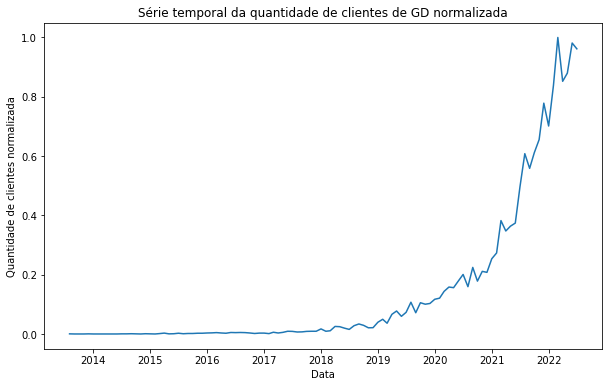

In [17]:
###############################
plt.plot(datasetSeries)

plt.xlabel('Data')
plt.ylabel('Quantidade de clientes normalizada') 
plt.title('Série temporal da quantidade de clientes de GD normalizada')

plt.show()


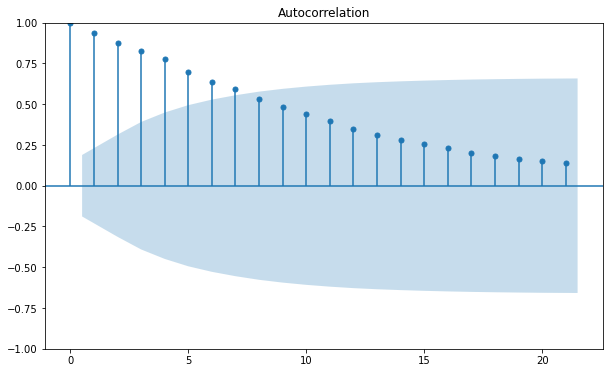

In [18]:
###############################
# Autocorrelacao
#acf_plot(datasetSeries, 40)
plot_acf(datasetSeries)
plt.show()


In [19]:
###############################
dimension = 6
stepahead = 1
datasetShifted = pd.concat([datasetSeries.shift(i) for i in range(dimension+stepahead) ],axis=1)

train = (datasetShifted.iloc[dimension:trainSize,1:])
trainTarget = (datasetShifted.iloc[dimension:trainSize,0])

valid = datasetShifted.iloc[trainSize:(validSize+trainSize),1:]
validTarget = datasetShifted.iloc[trainSize:(validSize+trainSize),0]

test = datasetShifted.iloc[(validSize+trainSize):,1:]
testTarget = datasetShifted.iloc[(validSize+trainSize):,0]


***
### LINEAR REGRESSION

MAE:  0.06568810712458943
MSE:  0.007225964804466976


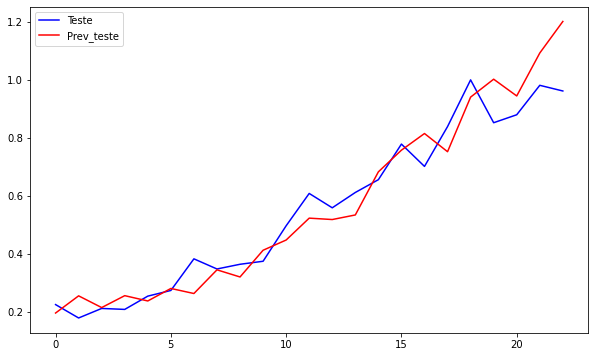

In [20]:
###############################
# LINEAR REGRESSION
modelo = LinearRegression()          
modelo.fit(train, trainTarget)

predVals = modelo.predict(valid)
erro = mse(predVals, validTarget)
#erroval.append(erro)
#param.append((i,j,k))
#if erro<bestValue:
#    bestValue = erro
#    bestModel = modelo
bestModel_lr = modelo

predTest = bestModel_lr.predict(test)
mseTest = mse(predTest, testTarget)

###############################
# Avaliando a Raiz do Erro Medio Quadratico
print("MAE: ", mae(testTarget.values, predTest))
print("MSE: ", mse(testTarget.values, predTest))

###############################
plt.plot(testTarget.values, 'b-')
plt.plot(predTest, 'r-')
plt.legend(['Teste', 'Prev_teste', 'No_Selection'])

predTest_lr = predTest


***
### SVR

In [21]:
###############################
# (bestModel, bestPredicts, bestError, bestParam)
gridSVR(train, trainTarget, valid, validTarget)


Best Param (Grid SVR): 


(SVR(C=1000, epsilon=0.001, gamma=0.01),
 array([0.02889601, 0.03522092, 0.0388061 , 0.03582796, 0.03139451,
        0.05837072, 0.06905577, 0.05689605, 0.07835022, 0.10419419,
        0.07674804, 0.10084232, 0.11627846, 0.107376  , 0.12011195,
        0.13017919, 0.13781192, 0.15279471, 0.15908534, 0.18314114,
        0.20340327]),
 0.000397226587208946,
 (3, -2, -3))

MAE:  0.05831217261661581
MSE:  0.0055891858191386735


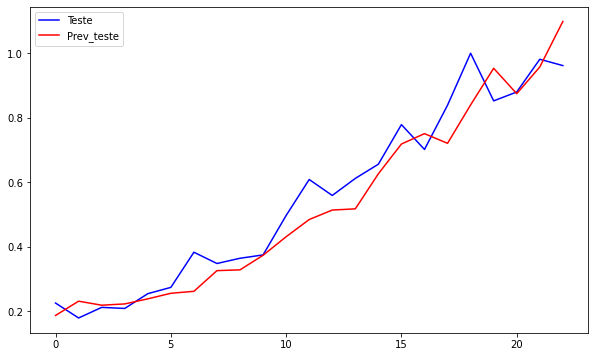

In [22]:
###############################
# SVR
bestValue = 10**100000
erroval = []
param=[]
bestModel_svr=0

'''
g = (10.0)**np.arange(-5,3,1) # 10
e = (10.0)**np.arange(-4,-1,1) # 10
c = (10.0)**np.arange(-2,3,1) # 10
'''

'''
for i in g:
    for j in e:
        for k in c:
            modelo = SVR(C=k, gamma=i, epsilon=j)            
            modelo.fit(train, trainTarget)
            
            predVals = modelo.predict(valid)
            erro = mse(predVals, validTarget)
            erroval.append(erro)
            param.append((i,j,k))
            if erro<bestValue:
                bestValue = erro
                bestModel_svr = modelo
'''

modelo = SVR(C=1000, gamma=0.01, epsilon=0.001)
modelo.fit(train, trainTarget)

predVals = modelo.predict(valid)
erro = mse(predVals, validTarget)
erroval.append(erro)
#param.append((i,j,k))
if erro<bestValue:
    bestValue = erro
    bestModel_svr = modelo

predTest = bestModel_svr.predict(test)
mseTest = mse(predTest,testTarget)

#SVR_no_Selection = SVR()
#SVR_no_Selection.fit(train,trainTarget)
#predTestNoSelection = SVR_no_Selection.predict(test)

#mseTest_noSelection = mse(predTestNoSelection,testTarget)

###############################
# Avaliando a Raiz do Erro Medio Quadratico
print("MAE: ", mae(testTarget.values, predTest))
print("MSE: ", mse(testTarget.values, predTest))

###############################
plt.plot(testTarget.values, 'b-')
plt.plot(predTest, 'r-')
plt.legend(['Teste', 'Prev_teste', 'No_Selection'])

predTest_svr = predTest


***
### RANDOM FOREST

In [23]:
###############################
# Random Forest
'''
param_grid_RF = {'n_estimators': [100, 200, 500],
               'max_features': ['auto', 'sqrt', 'log2'],
               'max_depth': [10, 50],
               'min_samples_split': [2, 5],
               'min_samples_leaf': [1, 3],
               'bootstrap': [True, False]}

modelo_rf = GridSearchCV(estimator = RandomForestRegressor(), param_grid = param_grid_RF, scoring = "neg_mean_squared_error", verbose = 0).fit(train, trainTarget)
predTest = modelo_rf.predict(test)


modelo_rf = RandomForestRegressor(n_estimators = 100)
modelo_rf.fit(train, trainTarget) 
predTest = modelo_rf.predict(test)

###############################
# Avaliando a Raiz do Erro Medio Quadratico
print("MAE: ", mae(testTarget.values, predTest))
print("MSE: ", mse(testTarget.values, predTest))

###############################
plt.plot(testTarget.values, 'b-')
plt.plot(predTest, 'r-')
plt.legend(['Teste','Prev_teste','No_Selection'])

predTest_rf = predTest
'''


'\nparam_grid_RF = {\'n_estimators\': [100, 200, 500],\n               \'max_features\': [\'auto\', \'sqrt\', \'log2\'],\n               \'max_depth\': [10, 50],\n               \'min_samples_split\': [2, 5],\n               \'min_samples_leaf\': [1, 3],\n               \'bootstrap\': [True, False]}\n\nmodelo_rf = GridSearchCV(estimator = RandomForestRegressor(), param_grid = param_grid_RF, scoring = "neg_mean_squared_error", verbose = 0).fit(train, trainTarget)\npredTest = modelo_rf.predict(test)\n\n\nmodelo_rf = RandomForestRegressor(n_estimators = 100)\nmodelo_rf.fit(train, trainTarget) \npredTest = modelo_rf.predict(test)\n\n###############################\n# Avaliando a Raiz do Erro Medio Quadratico\nprint("MAE: ", mae(testTarget.values, predTest))\nprint("MSE: ", mse(testTarget.values, predTest))\n\n###############################\nplt.plot(testTarget.values, \'b-\')\nplt.plot(predTest, \'r-\')\nplt.legend([\'Teste\',\'Prev_teste\',\'No_Selection\'])\n\npredTest_rf = predTest\n'

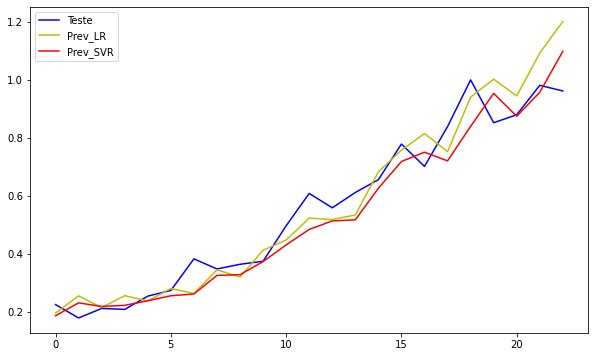

In [24]:
###############################
plt.plot(testTarget.values, 'b-')
plt.plot(predTest_lr, 'y-')
plt.plot(predTest_svr, 'r-')
#plt.plot(predTest_rf, 'g-')
plt.legend(['Teste', 'Prev_LR', 'Prev_SVR'])


***
# PREVISÃO ATÉ FINAL DE 2023

In [25]:
###############################
# 102 linhas de 08/2013 ate 07/2022
# + 05 ciclos: dez/2022
# + 17 ciclos: dez/2023
ciclos = 17

#modelo = bestModel_lr
modelo = bestModel_svr
#modelo = modelo_rf

# Pega ultima linha do teste
aux_set = test.iloc[(len(test)-1),]

# Lista vazia para guardar as previsoes
preds = []

# Loop para prever ciclos futuros
for x in range(ciclos):
    # Faz a previsao
    aux_pred = modelo.predict(np.array(aux_set).reshape(1,-1))
    # Shift para tirar o termo mais antigo e deixar o termo mais novo como NaN
    aux_set = aux_set.shift(1)
    # Termo mais novo fica como valor previsto
    aux_set[0] = aux_pred
    # Adiciona valor previsto a preds
    preds.append(aux_pred)

# Conversoes
preds = pd.Series(preds)
previsoes_df = preds.to_frame()
previsoes_df = previsoes_df.explode(0)
# Desnormaliza
desn = (maxData - minData) + minData
desn = desn[0]

previsoes_df.rename(columns={0:'quantidade_clientes_normalizado'}, inplace=True)
previsoes_df['quantidade_clientes'] = previsoes_df * desn


In [26]:
previsoes_df

,quantidade_clientes_normalizado,quantidade_clientes
0,1.098595,2637.726033
1,1.070839,2571.084366
2,1.028762,2470.057965
3,1.10784,2659.923158
4,1.211534,2908.892345
5,1.229932,2953.067522
6,1.193956,2866.689147
7,1.227632,2947.544163
8,1.315729,3159.064432
9,1.354468,3252.078828


In [27]:
###############################
# Coluna com os dados normalizados
dataset['quantidade_clientes_normalizado'] = (dataset - minData) / (maxData - minData)

# Junta dados conhecidos com dados previstos alem dos dados conhecidos
dataset_total = pd.concat([dataset, previsoes_df], ignore_index=True)

# Cria a data a partir dos 125 ciclos
d = pd.date_range(start='8/1/2013', end='12/1/2023', freq='MS')    
d = d.to_frame(index=False)
d = d.explode(0)
d.rename(columns={0:'data'}, inplace=True)

# Junta a data no dataset_total
dataset_total['data'] = d['data']
#dataset_total['data'] = dataset_total['data'].dt.strftime('%m/%Y')]

# Soma cumulativa dos dados nao normalizados
dataset_total['quantidade_clientes_acumulada'] = dataset_total['quantidade_clientes'].cumsum()

# Organizando ordem das colunas
dataset_total = dataset_total[['data', 'quantidade_clientes_normalizado', 'quantidade_clientes', 'quantidade_clientes_acumulada']]


In [28]:
pd.set_option('display.max_rows', 500)
dataset_total

,data,quantidade_clientes_normalizado,quantidade_clientes,quantidade_clientes_acumulada
0,2013-08-01,0.000416,1,1
1,2013-09-01,0.0,0,1
2,2013-10-01,0.0,0,1
3,2013-11-01,0.0,0,1
4,2013-12-01,0.000416,1,2
5,2014-01-01,0.0,0,2
6,2014-02-01,0.0,0,2
7,2014-03-01,0.0,0,2
8,2014-04-01,0.0,0,2
9,2014-05-01,0.0,0,2


In [29]:
dataset_total[dataset_total['data'] == '2022-12-01']

,data,quantidade_clientes_normalizado,quantidade_clientes,quantidade_clientes_acumulada
112,2022-12-01,1.211534,2908.892345,49890.683868


In [30]:
dataset_total[dataset_total['data'] == '2023-12-01']

,data,quantidade_clientes_normalizado,quantidade_clientes,quantidade_clientes_acumulada
124,2023-12-01,1.466856,3521.920429,88737.731301


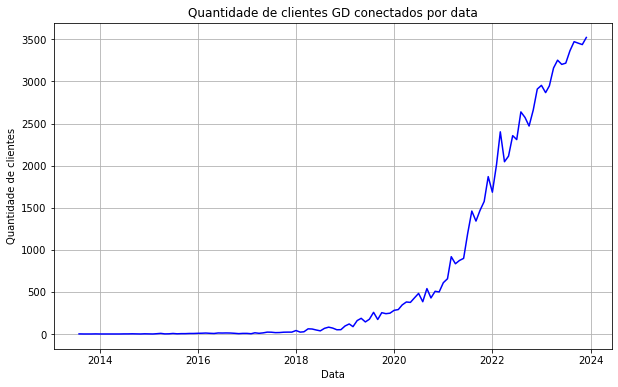

In [31]:
###############################
# Plota a serie com a previsao
data = np.array(dataset_total['data'])
plt.plot(data, dataset_total['quantidade_clientes'], 'b-')

plt.xlabel('Data')
plt.ylabel('Quantidade de clientes') 
plt.title('Quantidade de clientes GD conectados por data')

plt.grid()


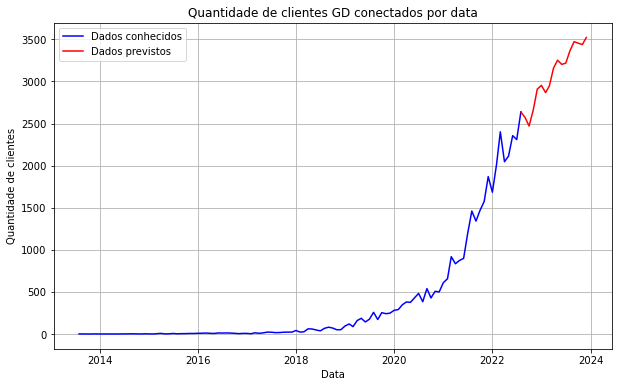

In [61]:
dados_conhecidos = dataset_total.loc[:108,:]
dados_previstos = dataset_total.loc[108:,:]

data = np.array(dataset_total['data'])
plt.plot(data[:109], dados_conhecidos['quantidade_clientes'], 'b-')
plt.plot(data[108:], dados_previstos['quantidade_clientes'], 'r-')

plt.xlabel('Data')
plt.ylabel('Quantidade de clientes') 
plt.title('Quantidade de clientes GD conectados por data')
plt.legend(['Dados conhecidos', 'Dados previstos'])

plt.grid()

In [32]:
del quantidade_clientes['quantidade_clientes_normalizado']
print(quantidade_clientes.to_latex(index=True))

\begin{tabular}{lr}
\toprule
{} &  quantidade\_clientes \\
data       &                      \\
\midrule
2013-08-01 &                    1 \\
2013-09-01 &                    0 \\
2013-10-01 &                    0 \\
2013-11-01 &                    0 \\
2013-12-01 &                    1 \\
2014-01-01 &                    0 \\
2014-02-01 &                    0 \\
2014-03-01 &                    0 \\
2014-04-01 &                    0 \\
2014-05-01 &                    0 \\
2014-06-01 &                    0 \\
2014-07-01 &                    1 \\
2014-08-01 &                    1 \\
2014-09-01 &                    2 \\
2014-10-01 &                    1 \\
2014-11-01 &                    0 \\
2014-12-01 &                    2 \\
2015-01-01 &                    1 \\
2015-02-01 &                    0 \\
2015-03-01 &                    3 \\
2015-04-01 &                    7 \\
2015-05-01 &                    1 \\
2015-06-01 &                    2 \\
2015-07-01 &                    6 \\
2015-08

In [33]:
print(potencia_instalada_kw.to_latex(index=True))

\begin{tabular}{lr}
\toprule
{} &  potencia\_instalada\_kw \\
data       &                        \\
\midrule
2013-08-01 &                   3.00 \\
2013-09-01 &                   0.00 \\
2013-10-01 &                   0.00 \\
2013-11-01 &                   0.00 \\
2013-12-01 &                 967.00 \\
2014-01-01 &                   0.00 \\
2014-02-01 &                   0.00 \\
2014-03-01 &                   0.00 \\
2014-04-01 &                   0.00 \\
2014-05-01 &                   0.00 \\
2014-06-01 &                   0.00 \\
2014-07-01 &                 361.64 \\
2014-08-01 &                   2.35 \\
2014-09-01 &                  55.02 \\
2014-10-01 &                   8.28 \\
2014-11-01 &                   0.00 \\
2014-12-01 &                  11.51 \\
2015-01-01 &                  13.80 \\
2015-02-01 &                   0.00 \\
2015-03-01 &                  51.80 \\
2015-04-01 &                  29.50 \\
2015-05-01 &                   5.00 \\
2015-06-01 &                  10

In [34]:
datasetShifted

,quantidade_clientes,quantidade_clientes,quantidade_clientes,quantidade_clientes,quantidade_clientes,quantidade_clientes,quantidade_clientes
data,,,,,,,
2013-08-01,0.000416,NaN,NaN,NaN,NaN,NaN,NaN
2013-09-01,0.000000,0.000416,NaN,NaN,NaN,NaN,NaN
2013-10-01,0.000000,0.000000,0.000416,NaN,NaN,NaN,NaN
2013-11-01,0.000000,0.000000,0.000000,0.000416,NaN,NaN,NaN
2013-12-01,0.000416,0.000000,0.000000,0.000000,0.000416,NaN,NaN
2014-01-01,0.000000,0.000416,0.000000,0.000000,0.000000,0.000416,NaN
2014-02-01,0.000000,0.000000,0.000416,0.000000,0.000000,0.000000,0.000416
2014-03-01,0.000000,0.000000,0.000000,0.000416,0.000000,0.000000,0.000000
2014-04-01,0.000000,0.000000,0.000000,0.000000,0.000416,0.000000,0.000000


In [35]:
print(datasetShifted.to_latex(index=False))

\begin{tabular}{rrrrrrr}
\toprule
 quantidade\_clientes &  quantidade\_clientes &  quantidade\_clientes &  quantidade\_clientes &  quantidade\_clientes &  quantidade\_clientes &  quantidade\_clientes \\
            0.000416 &                  NaN &                  NaN &                  NaN &                  NaN &                  NaN &                  NaN \\
\midrule
            0.000000 &             0.000416 &                  NaN &                  NaN &                  NaN &                  NaN &                  NaN \\
            0.000000 &             0.000000 &             0.000416 &                  NaN &                  NaN &                  NaN &                  NaN \\
            0.000000 &             0.000000 &             0.000000 &             0.000416 &                  NaN &                  NaN &                  NaN \\
            0.000416 &             0.000000 &             0.000000 &             0.000000 &             0.000416 &                  NaN &   

In [36]:
print(dataset_total.to_latex(index=True))

\begin{tabular}{lllll}
\toprule
{} &       data & quantidade\_clientes\_normalizado & quantidade\_clientes & quantidade\_clientes\_acumulada \\
\midrule
0   & 2013-08-01 &                        0.000416 &                   1 &                             1 \\
1   & 2013-09-01 &                             0.0 &                   0 &                             1 \\
2   & 2013-10-01 &                             0.0 &                   0 &                             1 \\
3   & 2013-11-01 &                             0.0 &                   0 &                             1 \\
4   & 2013-12-01 &                        0.000416 &                   1 &                             2 \\
5   & 2014-01-01 &                             0.0 &                   0 &                             2 \\
6   & 2014-02-01 &                             0.0 &                   0 &                             2 \\
7   & 2014-03-01 &                             0.0 &                   0 &                 

In [37]:
# Variancia
dataset_total.var()

quantidade_clientes_normalizado    2.107603e-01
quantidade_clientes                1.214991e+06
quantidade_clientes_acumulada      4.920411e+08
dtype: float64

In [38]:
# Desvio padrao
dataset_total.std()

data                               1102 days 15:53:53.999343776
quantidade_clientes_normalizado                        0.459086
quantidade_clientes                                 1102.266308
quantidade_clientes_acumulada                      22181.998343
dtype: object

In [39]:
dataset_total.describe()

,data,quantidade_clientes_normalizado,quantidade_clientes,quantidade_clientes_acumulada
count,125,125.0,125.0,125.0
unique,125,88.0,88.0,114.0
top,2013-08-01 00:00:00,0.0,0.0,2.0
freq,1,11.0,11.0,7.0
first,2013-08-01 00:00:00,NaN,NaN,NaN
last,2023-12-01 00:00:00,NaN,NaN,NaN


In [40]:
print(quantidade_clientes.to_latex(index=True))

\begin{tabular}{lr}
\toprule
{} &  quantidade\_clientes \\
data       &                      \\
\midrule
2013-08-01 &                    1 \\
2013-09-01 &                    0 \\
2013-10-01 &                    0 \\
2013-11-01 &                    0 \\
2013-12-01 &                    1 \\
2014-01-01 &                    0 \\
2014-02-01 &                    0 \\
2014-03-01 &                    0 \\
2014-04-01 &                    0 \\
2014-05-01 &                    0 \\
2014-06-01 &                    0 \\
2014-07-01 &                    1 \\
2014-08-01 &                    1 \\
2014-09-01 &                    2 \\
2014-10-01 &                    1 \\
2014-11-01 &                    0 \\
2014-12-01 &                    2 \\
2015-01-01 &                    1 \\
2015-02-01 &                    0 \\
2015-03-01 &                    3 \\
2015-04-01 &                    7 \\
2015-05-01 &                    1 \\
2015-06-01 &                    2 \\
2015-07-01 &                    6 \\
2015-08